# Deep Learning Models (LSTM & GRU)

### Libraries

In [246]:
#Tensorflow
import tensorflow as tf
import keras
from keras.layers import LSTM, Dense, InputLayer, GRU, Normalization
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.losses import MeanAbsoluteError, MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam, SGD

#Data Manipulation
import numpy as np
import pandas as pd

#Functionalities
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

#Plots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

keras.utils.set_random_seed(812)
tf.config.experimental.enable_op_determinism()

parameters = {
    "dataset":{
        "path": "../data/data_casal_montserratina/LaMonserratina_CLEAN.csv",
        "trainingSize": .60,
        "validationSize": .2,
        "testSize": .2
    },
    "backtesting":{
        "steps": 96,
        "fixedTrainSize": False,
        "refit": False,
    },
    "validation": {
        "n_splits" : 10
    },
    "lstm":{
        "epochs": 50,
        "batch_size": 64
    }
}

In [247]:
print("Keras backend:", keras.backend.backend())
print("TensorFlow version:", tf.__version__)
print("GPUs Available:", tf.config.list_physical_devices('GPU'))

Keras backend: tensorflow
TensorFlow version: 2.16.1
GPUs Available: []


In [248]:
#Use GPU if possible
if len(tf.config.list_physical_devices('GPU')) != 0:
    tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU')[0], True)

### Read and Split Dataset

In [249]:
#Read df
df = pd.read_csv(parameters['dataset']['path'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12046 entries, 0 to 12045
Data columns (total 41 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date                           12046 non-null  object 
 1   temperature_2m_C               12046 non-null  float64
 2   relative_humidity_2m_%         12046 non-null  float64
 3   dew_point_2m_C                 12046 non-null  float64
 4   apparent_temperature_C         12046 non-null  float64
 5   pressure_msl_hPa               12046 non-null  float64
 6   surface_pressure_hPa           12046 non-null  float64
 7   cloud_cover_%                  12046 non-null  float64
 8   cloud_cover_high_%             12046 non-null  float64
 9   et0_fao_evapotranspiration_mm  12046 non-null  float64
 10  vapour_pressure_deficit_kPa    12046 non-null  float64
 11  wind_speed_10m_km/h            12046 non-null  float64
 12  wind_direction_10m_º           12046 non-null 

In [250]:
#Change Data Types
def parseData(df):
    for col in df:
        df[col] = df[col].astype(float)
    return df

#Normalize Data
def normalizeData(data):
    df = data.copy()
    scaler = MinMaxScaler()
    return scaler.fit_transform(df)

#Add N Lags
def addNLags(df, lags_list):
    lag_df = df.copy()
    for lag in lags_list:
        lag_df[f'lag_{lag}'] = lag_df["Demanda_kWh"].shift(lag * 24)

    return lag_df.fillna(0)

In [251]:
#Drop Columns
dates = df["Date"]
dates = pd.to_datetime(dates)
df = df.drop("Date", axis=1)

In [252]:
#Convert to float
df = parseData(df)
df = df.dropna()
df["Demanda_kWh"] = np.log1p(df["Demanda_kWh"].values)
df = addNLags(df, [1,2,3,5,7])

y = df["Demanda_kWh"]
X = df.drop(columns=["Demanda_kWh", "pressure_msl_hPa", "dew_point_2m_C", "surface_pressure_hPa",
    "cloud_cover_%", "cloud_cover_high_%", "et0_fao_evapotranspiration_mm", "vapour_pressure_deficit_kPa",
    "wind_speed_10m_km/h", "wind_direction_10m_º", "wind_gusts_10m", "terrestrial_radiation_W/m2",
    "DayOfYear", "DayOfWeek", "temp_cluster", "Season", "Month", "relative_humidity_2m_%", "Month_sin", "is_day", "DayOfYear_sin", "sunshine_duration_sec",
    "direct_radiation_W/m2", "global_tilted_irradiance_W/m2", "DayOfYear_cos", "DayOfWeek_cos", "apparent_temperature_C", "Temp_interna_Modulo_C", "Year"], axis=1)
col_names = list(X.columns)

#Convert df to np

X = X.to_numpy()
y = y.to_numpy()

trainingSize = int(parameters["dataset"]["trainingSize"] * df.shape[0])
validationSize = trainingSize + int(parameters["dataset"]["validationSize"] * df.shape[0])

X_train, y_train = X[:trainingSize, :].copy(), y[:trainingSize].copy()
X_val, y_val = X[trainingSize:validationSize, :].copy(), y[trainingSize:validationSize].copy()
X_test, y_test = X[validationSize:, :].copy(), y[validationSize:].copy()

X_train_dates = dates.loc[:trainingSize].copy()
X_val_dates = dates.loc[trainingSize:validationSize].copy()
X_test_dates = dates.loc[validationSize:].copy()
print(f"Total Lags: {len(df)}")
print(f"Training Size:{len(X_train)}")
print(f"Validation Size:{len(X_val)}")
print(f"Test Size: {len(X_test)}")
df.columns
X_train = normalizeData(X_train)
X_val = normalizeData(X_val)
X_test = normalizeData(X_test)

#Reshape Datasets
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
y_train = y_train.reshape((y_train.shape[0], 1))
y_val = y_val.reshape((y_val.shape[0], 1))
y_test = y_test.reshape((y_test.shape[0], 1))

print(f"Training ==> X Shape: {X_train.shape}, y Shape: {y_train.shape}")
print(f"Validation ==> X Shape: {X_val.shape}, y Shape: {y_val.shape}")
print(f"Test ==> X Shape: {X_test.shape}, y Shape: {y_test.shape}")


Total Lags: 12046
Training Size:7227
Validation Size:2409
Test Size: 2410
Training ==> X Shape: (7227, 16, 1), y Shape: (7227, 1)
Validation ==> X Shape: (2409, 16, 1), y Shape: (2409, 1)
Test ==> X Shape: (2410, 16, 1), y Shape: (2410, 1)


### <b>Plots</b>

#### Predictions & Real Values

In [253]:
def plotPredictions(dates, y_pred, y_test, filename=None):
    fig = go.Figure()
    trace1 = go.Scatter(x=dates, y=y_test, name="test", mode="lines")
    trace2 = go.Scatter(x=dates, y=y_pred, name="predictions", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title="Real value vs Predicted in Test Data",
        xaxis_title="Date Time",
        yaxis_title="Demand",
        width=1020,
        height=450,
        margin = dict(l=70, r=20, t=55, b=20),
        legend = dict(
            orientation = "h",
            yanchor="top",
            y=1.1,
            xanchor="left",
            x=0.76
        )
    )
    if filename is not None:
        fig.write_image(f"../results/{filename}.png", format="png", scale=2, width=1000)
    fig.show()

#### Plot Losses 

In [254]:
def plotLosses(train_loss, validation_loss):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_loss, name="Training Loss", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_loss, name="Validation Loss", mode="lines")
    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.update_layout(
        title = "Training and Validation Losses",
        xaxis_title = "Epoch",
        yaxis_title = "MSE Loss Value",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

#### Plot Metrics

In [255]:
def plotMetrics(train_rmse, validation_rmse, train_mae, validation_mae):
    epochs_list = np.arange(0, 50)
    fig = go.Figure()
    trace1 = go.Scatter(x=epochs_list, y=train_rmse, name="Training RMSE", mode="lines")
    trace2 = go.Scatter(x=epochs_list, y=validation_rmse, name="Validation RMSE", mode="lines")
    trace3 = go.Scatter(x=epochs_list, y=train_mae, name="Training MAE", mode="lines")
    trace4 = go.Scatter(x=epochs_list, y=validation_mae, name="Validation MAE", mode="lines")

    fig.add_trace(trace1)
    fig.add_trace(trace2)
    fig.add_trace(trace3)
    fig.add_trace(trace4)
    fig.update_layout(
        title = "Metrics in Training/Validation",
        xaxis_title = "Epoch",
        yaxis_title = "RMSE / MAE",
        width = 800,
        height = 400,
        margin = dict(l=40, r=30, t=50, b=30),
        legend = dict(
            orientation = "h",
            yanchor = "top",
            y = .98,
            xanchor = "right",
            x = .98
        ) 
    )
    fig.show()

### Find Best Models

In [256]:
def selectModels(model_params, data, parameters):
    X_train, y_train = data["train"]["X"], data["train"]["y"]
    X_val, y_val = data["validation"]["X"], data["validation"]["y"]
    X_test, y_test = data["test"]["X"], data["test"]["y"]
    results = pd.DataFrame(columns=["Model", "nUnits", "nLayers", "dropout", "Loss_All", "MAE", "RMSE"])
    for param in tqdm(ParameterGrid(model_params), total=len(list(ParameterGrid(model_params)))):
        units = param.get('nUnits')
        layers = param.get("nLayers")
        dropout = param.get("dropout")
        days = param.get("days")
        #Build LSTM Model
        lstm_model = Sequential()
        for _ in range(layers - 1):
            lstm_model.add(LSTM(units=units, return_sequences=True, dropout=dropout))
        lstm_model.add(LSTM(units=units, dropout=dropout))
        lstm_model.add(Dense(1))

        #Compile LSTM Model
        lstm_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
        lstm_model.fit(X_train, y_train, epochs = 40, batch_size = parameters["lstm"]["batch_size"], validation_data=(X_val, y_val), verbose=True)

        #Eval LSTM Model
        lstm_loss, lstm_mae, lstm_rmse = lstm_model.evaluate(
            x = X_test,
            y = y_test,
            batch_size = parameters["lstm"]["batch_size"],
            verbose=False
        )
        results.loc[len(results.index)] = ['LSTM', units, layers, dropout, lstm_loss, lstm_mae, lstm_rmse] 

        #Build GRU Model
        gru_model = Sequential()
        for _ in range(layers - 1):
            gru_model.add(GRU(units=units, return_sequences=True, dropout=dropout))
        gru_model.add(GRU(units=units, dropout=dropout))
        gru_model.add(Dense(1))

        #Compile GRU Model
        gru_model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[MeanAbsoluteError(), RootMeanSquaredError()])
        gru_model.fit(X_train, y_train, epochs = 40, batch_size = parameters["lstm"]["batch_size"], validation_data=(X_val, y_val), verbose=True)

        #Eval GRU Model
        gru_loss, gru_mae, gru_rmse = gru_model.evaluate(
            x = X_test,
            y = y_test,
            batch_size = parameters["lstm"]["batch_size"],
            verbose=False
        )
        results.loc[len(results.index)] = ['GRU', units, layers, dropout, gru_loss, gru_mae, gru_rmse] 

    return results.sort_values(by=["RMSE", "MAE"])

data = {
    "train" : { "X" : X_train, "y" : y_train },
    "validation": { "X" : X_val, "y" : y_val },
    "test": { "X" : X_test, "y": y_test}
}

models_params = {
    'nUnits': [64, 128],     
    'nLayers': [1, 2],        
    'dropout': [0.0, 0.1]
}

#results = selectModels(models_params, data, parameters)
#results

### <b>Train One Model</b>

#### Select Model

In [257]:
#Choose Model
def get_LSTM_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(LSTM(units=n_units, activation='tanh',kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(LSTM(n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='linear'))
    return model

def get_GRU_Model(num_features, n_units, n_layers, dropout):
    model = Sequential()
    model.add(InputLayer((num_features, 1)))
    for _ in range(n_layers - 1):
        model.add(GRU(units=n_units, kernel_initializer='glorot_normal', return_sequences=True, dropout=dropout))
    model.add(GRU(n_units, activation='relu', kernel_initializer='glorot_normal'))
    model.add(Dense(1, activation='linear'))
    return model

model = get_LSTM_Model(X_train.shape[1], 128, 1, 0.2)
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Compile Model

In [258]:
#Comp
model.compile(
    loss = "mse", 
    optimizer=Adam(learning_rate=0.0005), 
    metrics=[
        MeanAbsoluteError(),
        RootMeanSquaredError()
    ]
)

#### Train Model

In [259]:
train_history = model.fit(
    np.concatenate([X_train, X_val], axis=0), 
    np.concatenate([y_train, y_val], axis=0), 
    epochs=100,
    batch_size = parameters["lstm"]["batch_size"]
)

Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.4910 - mean_absolute_error: 0.9683 - root_mean_squared_error: 1.1831 
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.3318 - mean_absolute_error: 0.4444 - root_mean_squared_error: 0.5759
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3125 - mean_absolute_error: 0.4296 - root_mean_squared_error: 0.5589
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2994 - mean_absolute_error: 0.4193 - root_mean_squared_error: 0.5471
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2840 - mean_absolute_error: 0.4077 - root_mean_squared_error: 0.5328
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2716 - mean_absolute_error: 0.3942 - root_mean_squared_error: 0.5211
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.2645 - mean_absolute_error: 0.3877 - root_mean_squared_error: 0.5142
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.2576 

#### Evaluate Model 

In [260]:
y_pred = model.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
).flatten()
y_pred = np.expm1(y_pred)
y_test = np.expm1(y_test.flatten())


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


In [261]:
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
print(f"MAE: {mae}, RMSE: {rmse}")

MAE: 1.6869738960208307, RMSE: 3.2630192411553764


In [262]:
plotPredictions(X_test_dates, y_pred, y_test)

In [263]:
plotPredictions(X_test_dates[:96*7], predictions.flatten()[:96*7], y_test.flatten()[:96*7])

NameError: name 'predictions' is not defined

In [1]:
plotLosses(train_history.history["loss"], train_history.history["val_loss"])

NameError: name 'plotLosses' is not defined

In [ ]:
plotMetrics(train_history.history["root_mean_squared_error"], train_history.history["val_root_mean_squared_error"], train_history.history["mean_absolute_error"], train_history.history["val_mean_absolute_error"])

100%|██████████| 24/24 [00:26<00:00,  1.12s/it]


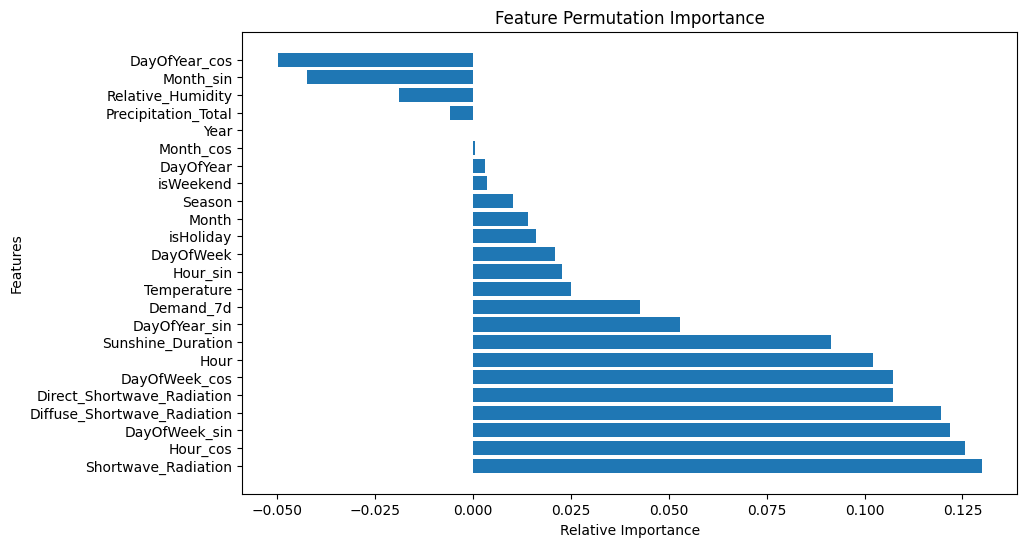

In [ ]:
from sklearn.utils import shuffle
def permutation_feature_importance(model, X_test, y_test, feature_names):
    y_pred = model.predict(X_test, verbose=False)
    #rmse_ref = root_mean_squared_error(y_test.flatten(), y_pred.flatten())
    mae_ref = mean_absolute_error(y_test.flatten(), y_pred.flatten())

    feature_importance = np.zeros(X_test.shape[1])

    for i in tqdm(range(X_test.shape[1]), total=(X_test.shape[1])):
        #Make a Copy of the Test Subset and Permute its values
        X_test_permuted = X_test.copy()
        X_test_permuted[:, i] = shuffle(X_test_permuted[:, i])

        #Calculate the metrics
        y_pred_permuted = model.predict(X_test_permuted, verbose=False)
        #rmse_permuted = root_mean_squared_error(y_test.flatten(), y_pred_permuted.flatten())
        mae_permuted = mean_absolute_error(y_test.flatten(), y_pred_permuted.flatten())

        #Calculate the difference in the metrics
        feature_importance[i] = mae_ref - mae_permuted
    
    #Normalize feature importances
    feature_importance /= feature_importance.sum()

    #Sort indexes
    sorted_indexes = feature_importance.argsort()[::-1]
    sorted_importances = feature_importance[sorted_indexes]
    sorted_importances_names = feature_names[sorted_indexes]

    #Bar Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_importances)), sorted_importances, align='center')
    plt.yticks(range(len(sorted_importances)), sorted_importances_names)
    plt.xlabel('Relative Importance')
    plt.ylabel('Features')
    plt.title('Feature Permutation Importance')
    plt.show()

permutation_feature_importance(model, X_test, y_test, X_columns)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * np.exp(-0.1)
scheduler_callback = LearningRateScheduler(scheduler)

model = get_GRU_Model(X_train.shape[1], 64, 1, 0.0)


model.compile(
    loss=MeanSquaredError(), 
    optimizer=Adam(learning_rate=0.0001), 
    metrics=[
        MeanAbsoluteError(),
        RootMeanSquaredError()
    ]
)
train_history = model.fit(
    X_train, 
    y_train, 
    validation_data=(X_val, y_val), 
    epochs=parameters["lstm"]["epochs"],
    batch_size = parameters["lstm"]["batch_size"],
    callbacks=[scheduler_callback]
)
predictions = model.predict(
    x = X_test,
    batch_size = parameters["lstm"]["batch_size"]
)
test_history = model.evaluate(
    x = X_test,
    y = y_test,
    batch_size = parameters["lstm"]["batch_size"],
)
plotPredictions(X_test_dates, predictions.flatten(), y_test.flatten())
print("MAE: ", mean_absolute_error(y_true=y_test.flatten(), y_pred=predictions.flatten()), ", RMSE: ", root_mean_squared_error(y_true=y_test.flatten(), y_pred=predictions.flatten()))

Epoch 1/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 3442.2871 - mean_absolute_error: 40.3427 - root_mean_squared_error: 58.4429 - val_loss: 1796.6360 - val_mean_absolute_error: 34.4155 - val_root_mean_squared_error: 42.3867 - learning_rate: 1.0000e-04
Epoch 2/50
767/767 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 2041.3651 - mean_absolute_error: 35.2700 - root_mean_squared_error: 45.1792 - val_loss: 1729.3331 - val_mean_absolute_error: 32.7733 - val_root_mean_squared_error: 41.5853 - learning_rate: 1.0000e-04
Epoch 3/50
341/767 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 1989.8658 - mean_absolute_error: 34.4160 - root_mean_squared_error: 44.6052

KeyboardInterrupt: 

In [ ]:
plotMetrics(train_history.history["root_mean_squared_error"], train_history.history["val_root_mean_squared_error"], train_history.history["mean_absolute_error"], train_history.history["val_mean_absolute_error"])

100%|██████████| 22/22 [00:22<00:00,  1.04s/it]


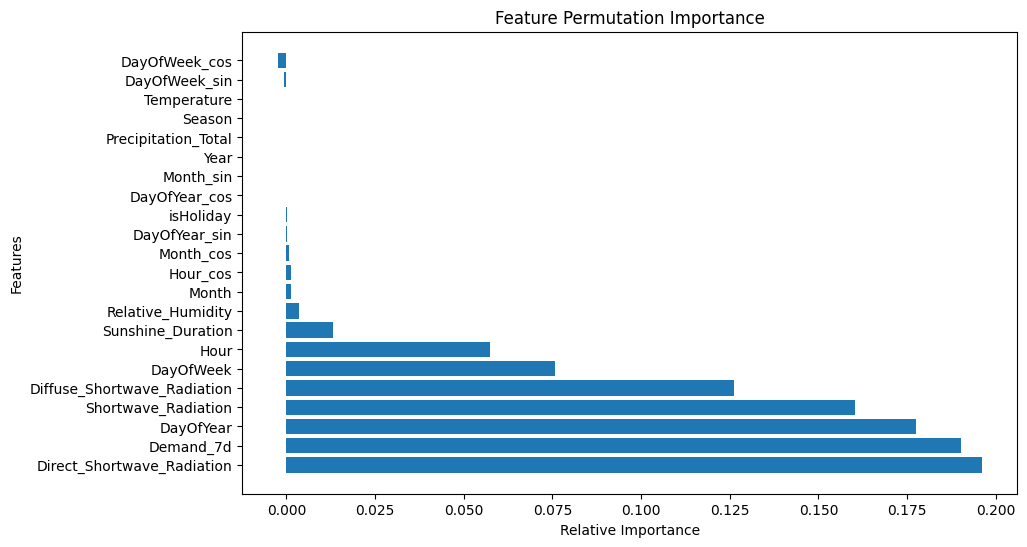

In [ ]:
permutation_feature_importance(model, X_test, y_test, X_columns)